In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.decomposition import LatentDirichletAllocation

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer, PorterStemmer

%matplotlib inline

import matplotlib.ticker as plticker

# Import DataFrame

In [6]:
ariana = pd.read_csv('../01_data/ariana2019.csv')

The caption_words list is terms used in to label song lyrics from Genius. We don't want this to get confused or take extra weight in our data

In [ ]:
caption_words = ['Verse 1', 'Intro', 'Shangela Laquifa Wadley', 'Marjorie Grande',
                'Wende Rene', 'Verse 2', 'Chorus', 'Bridge', 'Doug Middlebrook']

In [ ]:
#remove punctuation from lyrics column 
ariana['lyrics'] = ariana['lyrics'].str.replace('[^\w\s]', "")
#remove caption words
ariana['lyrics'] = ariana['lyrics'].str.replace('|'.join(caption_words), "")
#lowercase
ariana['lyrics'] = ariana['lyrics'].map(lambda x: x.lower())
#word count column
ariana['word_count'] = ariana['lyrics'].apply(lambda x: len(x.split()))
#unique word count
ariana['unique_word'] = ariana['lyrics'].apply(set).apply(len)

Below are the top three songs with the most unique words and the most overall word count in a song. Bloodline is the only Ariana Grande song in both charts.

In [18]:
ariana.sort_values(by = "unique_word", ascending = False)[['song', 'unique_word']][:3]

,song,unique_word
3,​bloodline,26
6,​make up,26
8,​in my head,26


In [19]:
ariana.sort_values(by = "word_count", ascending = False)[['song', 'word_count']][:3]

,song,word_count
3,​bloodline,531
9,7 rings,492
10,"​thank u, next",462


# Sentiment analyzer

- sia_positive : Scale of 0.0 - 1.0
- sia_negative : Scale of 0.0 - 1.0
- sia_neutral : Scale of 0.0 - 1.0
- sia_compound : Scale of -1.0 - 1.0

In [20]:
sia = SentimentIntensityAnalyzer()

In [21]:
sia_table = []
for i in ariana['lyrics']:
    sia_scores = {}
    sia_scores['sia_positive'] = sia.polarity_scores(i)['pos']
    sia_scores['sia_negative'] = sia.polarity_scores(i)['neg']
    sia_scores['sia_neutral'] = sia.polarity_scores(i)['neu']
    sia_scores['sia_compound'] = sia.polarity_scores(i)['compound']

    sia_table.append(sia_scores)
    
sia_table = pd.DataFrame(sia_table)
ariana = pd.concat([ariana, sia_table], axis = 1)

Text(0.5, 1.0, 'Sentiment Analysis: thank u, next - Ariana Grande(2019)')

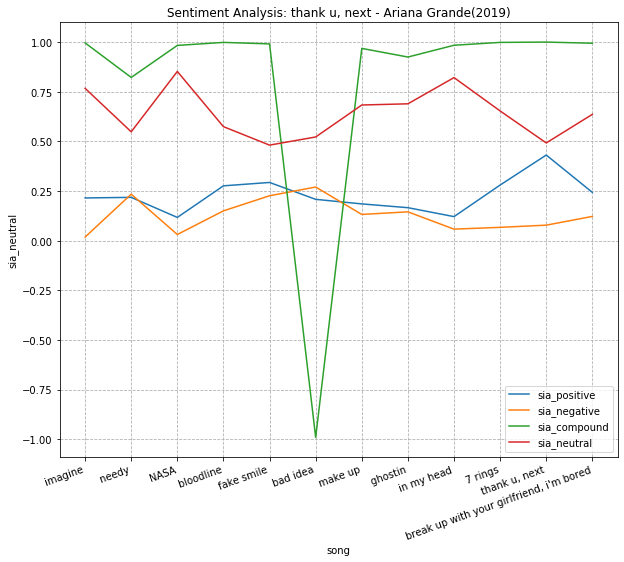

In [115]:
plt.figure(figsize = (10,8))
ax = plt.gca()
plt.setp(ax.get_xticklabels(), ha = "right", rotation = 20)
ax.xaxis.set_tick_params(labelbottom=True)
plt.grid('on', linestyle='--')


sns.lineplot(x = "song", y = "sia_positive", data= ariana, ax= ax, label = "sia_positive", sort = False)
sns.lineplot(x = "song", y = "sia_negative", data= ariana, ax= ax, label = "sia_negative", sort = False)
sns.lineplot(x = "song", y = "sia_compound", data= ariana, ax= ax, label = "sia_compound", sort = False)
sns.lineplot(x = "song", y = "sia_neutral", data= ariana, ax= ax, label = "sia_neutral", sort = False)


plt.legend(loc = "lower right")
plt.title("Sentiment Analysis: thank u, next - Ariana Grande(2019)")

# Most Common Terms

Investigating most common single, bi-, tri-, and quad- grams used throughout the album using CountVectorizer and TfidfVectorizer.

In [116]:
X = ariana['lyrics']

In [121]:
def ngramwords(vecttype, list_ngram, titlelist, list_colors):
    fig, ax = plt.subplots(nrows = 2, ncols = 4, figsize = (20,13))
    plt.subplots_adjust(hspace = 0.6)
    
    ax = ax.ravel()
    for i, vectorizer in enumerate(vecttype):
        vec = vectorizer(ngram_range = list_ngram[i])
        words_df = pd.DataFrame(vec.fit_transform(X).todense(), columns = vec.get_feature_names())
        top_10 = words_df.sum().sort_values(ascending = True).tail(10)
        top_10.plot.bar(ax = ax[i], color = list_colors[i])
        plt.setp(ax[i].get_xticklabels(), ha = "right", rotation = 45)
        
    for i, title in enumerate(titlelist):
        ax[i].set_title(title)

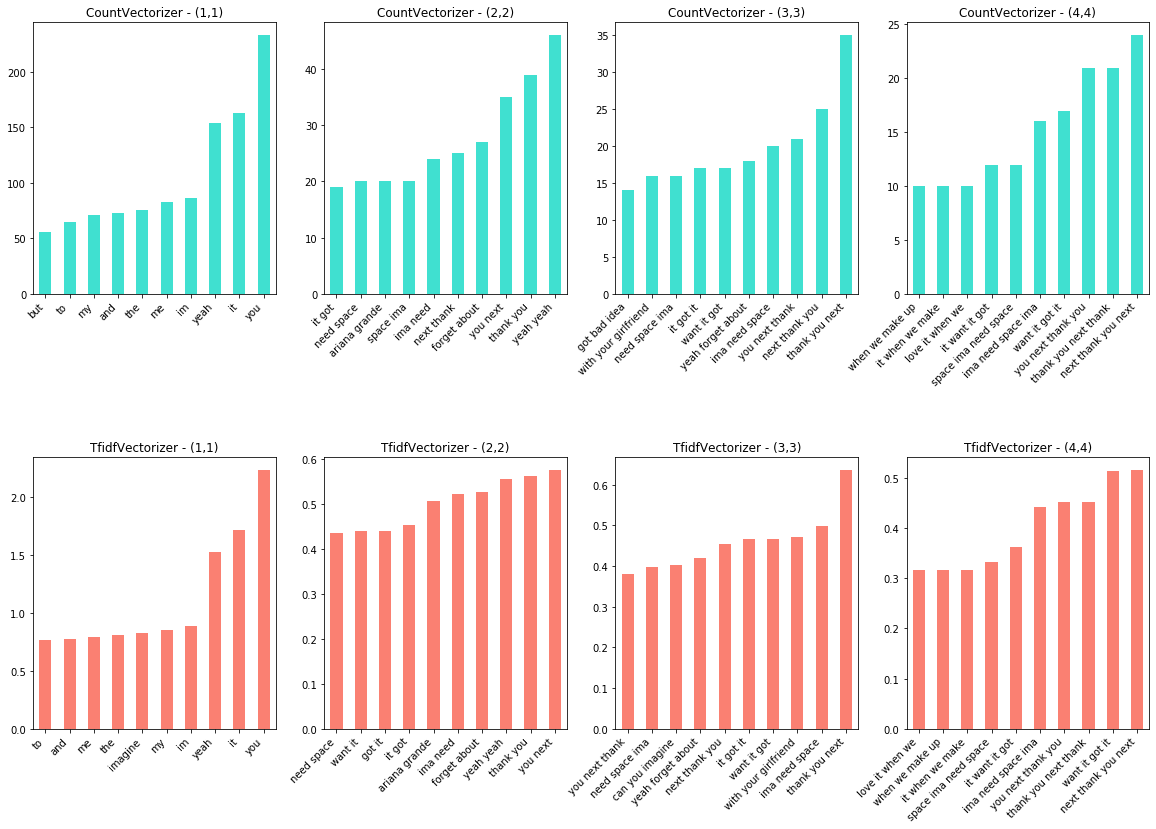

In [124]:
ngramwords([CountVectorizer, CountVectorizer, CountVectorizer,CountVectorizer, TfidfVectorizer, TfidfVectorizer, TfidfVectorizer, TfidfVectorizer],
          [(1,1), (2,2), (3,3), (4,4), (1,1), (2,2), (3,3), (4,4)],
          ['CountVectorizer - (1,1)', 'CountVectorizer - (2,2)', 'CountVectorizer - (3,3)', 'CountVectorizer - (4,4)',
          'TfidfVectorizer - (1,1)', 'TfidfVectorizer - (2,2)', 'TfidfVectorizer - (3,3)', 'TfidfVectorizer - (4,4)'],
          ['turquoise', 'turquoise', 'turquoise', 'turquoise', 'salmon', 'salmon', 'salmon', 'salmon'])

# LDA = Topic Modeling

In [128]:
tfidf = TfidfVectorizer(ngram_range = (2,3), token_pattern='\w+|\$[\d\.]+|\S+')
ariana_tf = tfidf.fit_transform(X).toarray()
ariana_featurenames = tfidf.get_feature_names()

In [129]:
lda_model = LatentDirichletAllocation(n_components=5, random_state = 77
                                     )
#fit model to lyrics
lda_model.fit(ariana_tf)

def display_topics(model, feature_names, no_top_words):
    topic_dict ={}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict['Topic %d words' % (topic_idx)] = ['{}'.format(feature_names[i])
                                                     for i in topic.argsort()[:-no_top_words - 1: -1]]
        topic_dict['Topic %d weights' % (topic_idx)] = ['{:.1f}'.format(topic[i])
                                                       for i in topic.argsort()[:-no_top_words -1 : -1]]
    return pd.DataFrame(topic_dict)

In [130]:
no_top_words = 4
display_topics(lda_model, ariana_featurenames, no_top_words)

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights
0,forget about,0.6,you next,0.6,ima need,0.6,it i,0.7,woo ah,0.5
1,your girlfriend,0.5,thank you next,0.6,need space,0.5,want it,0.4,fake smile,0.4
2,with your girlfriend,0.5,thank you,0.6,space ima,0.5,i want it,0.4,i cant,0.4
3,with your,0.5,next thank,0.5,ima need space,0.5,it i got,0.4,cant fake,0.4


In [133]:
ariana.to_csv('../01_data/ariana_eda.csv', index = False)